In [1]:
#  Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,BitsAndBytesConfig,pipeline
import os
import pandas as pd
import jsonlines
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments,Trainer
from peft import LoraModel, LoraConfig
from pprint import pprint

import datasets
from datasets import load_dataset

from prompt_template import template

In [2]:
#  GPU to use
gpu_to_use = 0
device = torch.device(f'cuda:{gpu_to_use}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
!gpustat

gpu-server           Sun Mar 17 14:30:31 2024  495.29.05
[0] Quadro RTX 5000  | 28'C,   0 % |    17 / 16122 MB | gdm(9M) gdm(3M)


In [4]:
#  Function to load model and tokenizer
def load_model_toks():

    tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1",
                                          load_in_4bit = True)
    tokenizer.pad_token = tokenizer.unk_token
    tokenizer.padding_side = "left"

    model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1",
                                                 device_map='auto',
                                                 load_in_4bit = True)

    return model, tokenizer
    
model, tokenizer = load_model_toks()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# Load dataset from hf
pretrained_dataset = load_dataset("ChobPT/gradio_docs_alpaca",split="train")


/home/user/miniconda3/envs/mayur2/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [6]:
pretrained_dataset

Dataset({
    features: ['instruction', 'output', 'input'],
    num_rows: 2231
})

#### 1.The dataset contains three cols: instruction, output, input
#### 2.A row in the dataset is a dict which has 3 keys, namely ['instruction', 'output', 'input'], and we have 2231 such rows
#### 3.We convert the pretrained_dataset to dict type so that it has only 3keys namely  ['instruction', 'output', 'input'], such that 
####     instruction key has all the 2231 instructions in the form of list, and same for output and input
#### 4. Then we create a prompt with only the instruction, and pass all the instructions into the prompt.
#### 5. Then we create a list which 2231 dict with each dict having two keys: instructions(with prompt) and output.

In [7]:
# Function to generate output given a prompt
def gen(prompt):
    toks = tokenizer(prompt,return_tensors = 'pt').to(device)
    output = model.generate(
        **toks,
        max_new_tokens = 300
    )
    output = output[0][len(toks.input_ids[0]):]
    output = tokenizer.decode(output)
    return output

In [8]:
#  preprocessing Method 2 (Fast)
    
examples = pretrained_dataset.to_dict()
prompt_template = """### Question:
{question}

### Answer:"""

num_examples = len(examples["instruction"])
finetuning_dataset = []
for i in range(num_examples):
  question = examples["instruction"][i]
  answer = examples["output"][i]
  text_with_prompt_template = prompt_template.format(question=question)
  finetuning_dataset.append({"question": text_with_prompt_template, "answer": answer})

    

In [9]:
# Setting pad token to unk_token,
#  Padding on the left

def tokenize_me(input):
    tokenizer.pad_token = tokenizer.unk_token
    tokenized_inputs = tokenizer(
        text = input, 
        return_tensors="pt",   
        padding=True     
    )
    return tokenized_inputs

In [10]:

def get_max_length():
    aindex = []
    qindex = []
    max_length = 0
    for i in range(len(finetuning_dataset)):
        aindex.append(tokenize_me(finetuning_dataset[i]['answer'])['input_ids'][0].shape[0])
        qindex.append(tokenize_me(finetuning_dataset[i]['question'])['input_ids'][0].shape[0])    
        text = finetuning_dataset[i]['question'] + finetuning_dataset[i]['answer']
        input_id_len = tokenize_me(text)['input_ids'][0].shape[0]
    
        if input_id_len>max_length:
            max_length = input_id_len       
        
    
    fig, axs = plt.subplots(1,2)
    
    # Plotting the first box plot
    axs[0].boxplot(qindex)
    axs[0].set_title('Qustion/instruction')
    
    # Plotting the second box plot
    axs[1].boxplot(aindex)
    axs[1].set_title('Answers')
    
    # Displaying the plot
    plt.tight_layout()
    plt.show()

    return max_length




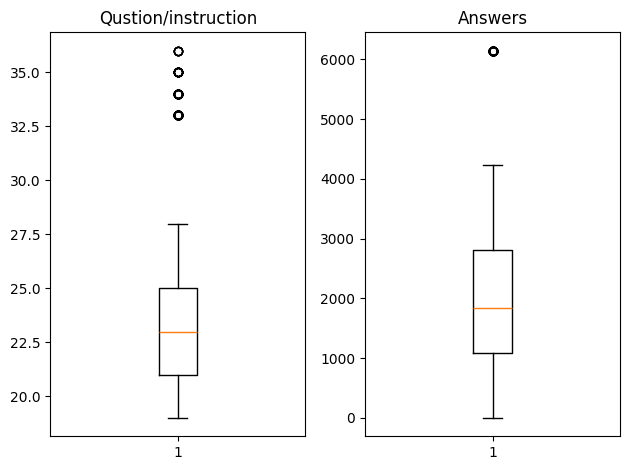

In [13]:
max_length = get_max_length()

In [12]:
# max_length = 4096

#### If we dont set max_length then the length of first input will be set as max length.

In [14]:
pretrained_dataset

Dataset({
    features: ['instruction', 'output', 'input'],
    num_rows: 2231
})

In [15]:
#  Padding Stratergy is left padding

def prompt_funct(example):    
  
    question = example["instruction"]
    answer = example["output"]
    # print(question)

    question_template = template.format(question = question)
    input = question_template + answer    
    return input

    

### Training Starts

In [16]:
from peft import AutoPeftModelForCausalLM, LoraConfig, get_peft_model, prepare_model_for_kbit_training

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM"
)

In [17]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [18]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(in_features=4096, out_features=1024,

In [19]:
from transformers import TrainingArguments

args = TrainingArguments(
  output_dir = "mistral_instruct_generation",
  #num_train_epochs=5,
  max_steps = 100, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 1,
  warmup_steps = 0.03,
  logging_steps=10,
  save_strategy="epoch",
  gradient_accumulation_steps = 4,
  #evaluation_strategy="epoch",
  # evaluation_strategy="steps",
  # eval_steps=20, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=2e-4,
  # bf16=True,
  lr_scheduler_type='constant',
)

In [20]:
from trl import SFTTrainer

max_seq_length = max_length

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  max_seq_length=max_length,
  tokenizer=tokenizer,
  packing=True,
  formatting_func=prompt_funct, # this will aplly the create_prompt mapping to all training and test dataset
  args=args,
  train_dataset=pretrained_dataset
  # eval_dataset=instruct_tune_dataset["test"]
)

/home/user/miniconda3/envs/mayur2/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/home/user/miniconda3/envs/mayur2/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [21]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/user/miniconda3/envs/mayur2/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,1.121800
20,1.098100
30,0.987900
40,0.943500


KeyboardInterrupt: 

A crucial point to note is the need to add padding to the left. This approach is adopted because the model generates tokens autoregressively, meaning it continues from the last token. Adding padding to the right would cause the model to generate new tokens from these padding tokens, resulting in the output sequence including padding tokens in the middle.